# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1hxmTOwCoQ1fWD22ECkmFSCqmwoIqOjf2/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Explanation**:
*   To split the data into training, validation, and testing, I created three corresponding directories in Google Drive. Each of the directories contains the 9 classes of hand shapes that we are trying to identify.

*   I decided to split the data into ~70% for training, ~15% for validation and ~15% for testing since this is a common ratio used in data splitting.

Reference: https://hasty.ai/docs/mp-wiki/splits/data-splitting-in-machine-learning#:~:text=The%20most%20common%20ratios%20of,better%20evaluation%20of%20your%20model.


In [3]:
###############################################################################
# Data Loading

data_PATH = '/content/drive/MyDrive/aps360Labs/LAB3_dataset/'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor()  # Convert images to tensor
])

# Load the dataset
train_data = ImageFolder(data_PATH + 'train', transform=transform)
val_data = ImageFolder(data_PATH + 'val', transform=transform)
test_data = ImageFolder(data_PATH + 'test', transform=transform)

# Create DataLoaders
batch_size = 36
num_workers = 1

train_loader = DataLoader(train_data, batch_size=batch_size,
                          num_workers=num_workers, shuffle=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                        num_workers=num_workers, shuffle=True)

test_loader = DataLoader(test_data, batch_size=batch_size,
                         num_workers=num_workers, shuffle=True)

In [17]:
# The percentage distribution of each set of data:
sum = len(train_data) + len(val_data) + len(test_data)

print("Percentage of data for Training: {:.3f}%".format((len(train_data)/sum)*100))
print("The number of images for Training: {} images\n".format(len(train_data)))

print("Percentage of data for Validation: {:.3f}%".format((len(val_data)/sum)*100))
print("The number of images for Validation: {} images\n".format(len(val_data)))

print("Percentage of data for Testing: {:.3f}%".format((len(test_data)/sum)*100))
print("The number of images for Testing: {} images\n".format(len(test_data)))

Percentage of data for Training: 69.175%
The number of images for Training: 1535 images

Percentage of data for Validation: 15.412%
The number of images for Validation: 342 images

Percentage of data for Testing: 15.412%
The number of images for Testing: 342 images



### 2. Model Building and Sanity Checking [15 pt]

#### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

**Explanation**:
* I implemented a neural network with three convolutional layers, followed by two fully connected layers.

* After each convolutional layer, I applied max pooling of kernel size 2.

* The ReLU activation function was my choice given its widespread adoption for its effectiveness.

* Initially, I was thinking to use double or even triple the number of feature maps and hidden units, since by doing so we would be able to capture more features as we go deeper the neural network. But, considering the need to maintain a balance between computational efficiency, I decide for the current configuration.

In [ ]:
torch.manual_seed(99) # set the random seed
from math import floor

class GestureClassifier(nn.Module):
  def __init__(self, name = "cnn_classifier"):
    super(GestureClassifier, self).__init__()
    self.name = name

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, stride=1, padding=1)
    self.conv2 = nn.Conv2d(in_channels=8, out_channels=12, kernel_size=3, stride=1, padding=1)
    self.conv3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=1, padding=1)

    # Pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Calculate the input size into the fc layers
    self.size1 = floor(((224 - 3 + 2)/1 + 1)/2) # 3-kernel size, 2-padding time 2, 1 - stride, /2 - max pooling
    self.size2 = floor(((self.size1 - 3 + 2)/1 + 1)/2) # 3-kernel size, 2-padding time 2, 1 - stride, /2 - max pooling
    self.size3 = floor(((self.size2 - 3 + 2)/1 + 1)/2) # 3-kernel size, 2-padding time 2, 1 - stride, /2 - max pooling
    self.fc_input = 24*self.size3*self.size3

    # Fully connected (ANN) layers
    self.fc1 = nn.Linear(self.fc_input, 32)  # The size 28*28 comes from the dimensions of the image after 3 pooling layers
    self.fc2 = nn.Linear(32, 9)  # 9 classes

  def forward(self, img):
    # Convolutional layers followed by pooling and ReLU activation
    img = self.pool(F.relu(self.conv1(img)))
    img = self.pool(F.relu(self.conv2(img)))
    img = self.pool(F.relu(self.conv3(img)))

    # Flatten the tensor
    img = img.view(-1, self.fc_input)

    # Fully connected layers with ReLU activation
    img = F.relu(self.fc1(img))

    # Final fully connected layer (no activation as it will be used with CrossEntropyLoss)
    img = self.fc2(img)

    return img

#### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

**Choices and reasoning:**

1. **Loss function**: For a classification problem, it's common to use the `CrossEntropyLoss` because it measures the performance of the classification model whose output is a probability value between 0 and 1. It is well-suited for comparing probability distributions, making it ideal for classification

2. **Optimizer**: On the other hand, the `Adam optimizer` is chosen because of its efficiency and little need for hyperparameter tuning. It combines the best properties of the AdaGrad and RMSProp optimization algorithms, resulting in smooth and effective optimization. In many empirical scenarios, Adam tends to outperform other optimization techniques in terms of both convergence speed and accuracy.

In [ ]:
# Helper function 1
def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
# Helper function 2
def get_accuracy(model, data_loader):
    correct_predictions = 0
    total_samples = 0

    for images, labels in data_loader:
        # If GPU is available, move tensors to GPU
        if use_cuda and torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()

        # Forward pass to get the model's predictions
        outputs = model(images)

        # Determine the index with the maximum prediction score for each sample
        predicted = outputs.max(1, keepdim=True)[1]

        # Count the number of correct predictions
        correct_predictions += predicted.eq(labels.view_as(predicted)).sum().item()

        # Update the total number of samples processed
        total_samples += images.size(0)

    # Calculate the accuracy
    accuracy = correct_predictions / total_samples

    return accuracy

In [ ]:
use_cuda = True

# Training ############################################################################ may need to be changed
def train(model, train_set, val_set, batch_size=128, num_epochs=20, learn_rate=0.001):
  torch.manual_seed(99) # set the random seed

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

  # Load in the datasets
  train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

  # Set up arrays to stroe the training/test accuracy
  train_acc = []
  val_acc = []

  # Let's get started
  print ("Training Started...")
  start_time = time.time()

  for epoch in range(num_epochs):  # loop over the dataset multiple times
    for imgs, labels in iter(train_loader):
      ########################################## speed up training for NN
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      ########################################## by using CUDA GPU acceleration

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward pass, backward pass, and optimize
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

    # Get acc results
    train_acc.append(get_accuracy(model, train_loader))
    train_acc[epoch] = get_accuracy(model, train_loader)

    val_acc.append(get_accuracy(model, val_loader))
    val_acc[epoch] = get_accuracy(model, val_loader)

    print(("Epoch {0}: Train accuracy: {1}, Validation accuracy: {2}").format(
                   epoch + 1,
                   train_acc[-1],
                   val_acc[-1]))

    # Save the current model (checkpoint) to a file
    model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
    torch.save(model.state_dict(), model_path)


  # used later on for plotting or indexing purposes
  epochs = np.arange(1, num_epochs + 1)

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total training time used: {:.2f} seconds".format(elapsed_time))

  return train_acc, val_acc, epochs

#### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

In [ ]:
use_cuda = True

# slightly modify the training function
def train_to_overfit(model, train_set, batch_size=32, num_epochs=30, learn_rate=0.001):
  torch.manual_seed(99) # set the random seed

  # Define the loss function and optimizer
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr=learn_rate, weight_decay=1e-4)

  # Set up  numpy arrays to stroe the training/test loss/erruracy
  train_acc = []

  # Let's get started
  print ("Training Started...")
  start_time = time.time()

  for epoch in range(num_epochs):  # loop over the dataset multiple times
    for imgs, labels in iter(train_set):
      ########################################## speed up training for NN
      if use_cuda and torch.cuda.is_available():
        imgs = imgs.cuda()
        labels = labels.cuda()
      ########################################## by using CUDA GPU acceleration

      # Forward pass, backward pass, and optimize
      outputs = model(imgs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Zero the parameter gradients
      optimizer.zero_grad()

    # Get accuracy results
    train_acc.append(get_accuracy(model, train_set))
    train_acc[epoch] = get_accuracy(model, train_set)

    print("Epoch: {0}, Accuracy: {1}".format(epoch, train_acc[-1]))

  print('Finished Training')
  end_time = time.time()
  elapsed_time = end_time - start_time
  print("Total training time used: {:.2f} seconds".format(elapsed_time))

  return

In [ ]:
# The smaller set of data
SMALL_PATH = '/content/drive/MyDrive/aps360Labs/LAB3_dataset/small'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to a common size
    transforms.ToTensor()  # Convert images to tensor
])

# Load the dataset
small_set = torchvision.datasets.ImageFolder(SMALL_PATH, transform=transform)
small_loader = torch.utils.data.DataLoader(small_set, batch_size=6, num_workers=1, shuffle=True)

In [ ]:
torch.manual_seed(99) # set the random seed
# Let's get started for overfitting
overfit_cnn = GestureClassifier()

##########################################
if torch.cuda.is_available():
  overfit_cnn.cuda()
##########################################

train_to_overfit(model=overfit_cnn, train_set=small_loader)

Training Started...
Epoch: 0, Accuracy: 0.1419753086419753
Epoch: 1, Accuracy: 0.13580246913580246
Epoch: 2, Accuracy: 0.16666666666666666
Epoch: 3, Accuracy: 0.30246913580246915
Epoch: 4, Accuracy: 0.46296296296296297
Epoch: 5, Accuracy: 0.5925925925925926
Epoch: 6, Accuracy: 0.7222222222222222
Epoch: 7, Accuracy: 0.7345679012345679
Epoch: 8, Accuracy: 0.7777777777777778
Epoch: 9, Accuracy: 0.845679012345679
Epoch: 10, Accuracy: 0.9135802469135802
Epoch: 11, Accuracy: 0.9444444444444444
Epoch: 12, Accuracy: 0.9567901234567902
Epoch: 13, Accuracy: 0.9753086419753086
Epoch: 14, Accuracy: 0.9876543209876543
Epoch: 15, Accuracy: 0.9814814814814815
Epoch: 16, Accuracy: 0.9938271604938271
Epoch: 17, Accuracy: 0.9753086419753086
Epoch: 18, Accuracy: 0.9567901234567902
Epoch: 19, Accuracy: 0.9814814814814815
Epoch: 20, Accuracy: 1.0
Epoch: 21, Accuracy: 0.9938271604938271
Epoch: 22, Accuracy: 1.0
Epoch: 23, Accuracy: 1.0
Epoch: 24, Accuracy: 1.0
Epoch: 25, Accuracy: 1.0
Epoch: 26, Accuracy: 1

### 3. Hyperparameter Search [10 pt]

#### Part (a) - 1 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

1. **Batch size**

2. **Learning rate**

3. **Extra Convolutional Layer w/ Regularization Techniques (model architecture)**

#### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

**Trial 0: Default Parameters**

In [ ]:
torch.manual_seed(99) # set the random seed
# Let's try our default one and see how well it goes
cnn = GestureClassifier(name="default")

##########################################
if torch.cuda.is_available():
  cnn.cuda()
##########################################

train_acc, val_acc, epochs = train(model=cnn, train_set=train_data, val_set=val_data)

Training Started...
Epoch 1: Train accuracy: 0.11291512915129151, Validation accuracy: 0.09004739336492891
Epoch 2: Train accuracy: 0.17638376383763837, Validation accuracy: 0.17061611374407584
Epoch 3: Train accuracy: 0.25461254612546125, Validation accuracy: 0.22037914691943128
Epoch 4: Train accuracy: 0.33653136531365313, Validation accuracy: 0.3009478672985782
Epoch 5: Train accuracy: 0.4656826568265683, Validation accuracy: 0.3933649289099526
Epoch 6: Train accuracy: 0.5542435424354244, Validation accuracy: 0.44549763033175355
Epoch 7: Train accuracy: 0.6841328413284132, Validation accuracy: 0.523696682464455
Epoch 8: Train accuracy: 0.666420664206642, Validation accuracy: 0.5497630331753555
Epoch 9: Train accuracy: 0.7033210332103321, Validation accuracy: 0.556872037914692
Epoch 10: Train accuracy: 0.6981549815498155, Validation accuracy: 0.556872037914692
Epoch 11: Train accuracy: 0.7476014760147601, Validation accuracy: 0.6042654028436019
Epoch 12: Train accuracy: 0.77859778597

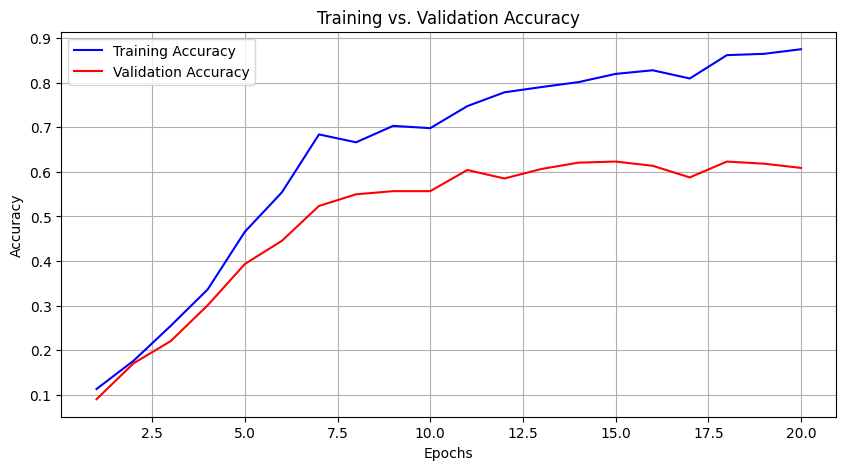

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='red')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Trial 1: Larger Batch Size**

In [ ]:
torch.manual_seed(99) # set the random seed
# Let's try our default one and see how well it goes
cnn = GestureClassifier(name="trial1")

##########################################
if torch.cuda.is_available():
  cnn.cuda()
##########################################

train_acc, val_acc, epochs = train(model=cnn, train_set=train_data, val_set=val_data, batch_size=256)

Training Started...
Epoch 1: Train accuracy: 0.12398523985239852, Validation accuracy: 0.12796208530805686
Epoch 2: Train accuracy: 0.24354243542435425, Validation accuracy: 0.20853080568720378
Epoch 3: Train accuracy: 0.18081180811808117, Validation accuracy: 0.16113744075829384
Epoch 4: Train accuracy: 0.25461254612546125, Validation accuracy: 0.2014218009478673
Epoch 5: Train accuracy: 0.26642066420664207, Validation accuracy: 0.20616113744075829
Epoch 6: Train accuracy: 0.2774907749077491, Validation accuracy: 0.23696682464454977
Epoch 7: Train accuracy: 0.3763837638376384, Validation accuracy: 0.31516587677725116
Epoch 8: Train accuracy: 0.44206642066420665, Validation accuracy: 0.35071090047393366
Epoch 9: Train accuracy: 0.5490774907749078, Validation accuracy: 0.46208530805687204
Epoch 10: Train accuracy: 0.6273062730627307, Validation accuracy: 0.5497630331753555
Epoch 11: Train accuracy: 0.6701107011070111, Validation accuracy: 0.5308056872037915
Epoch 12: Train accuracy: 0.6

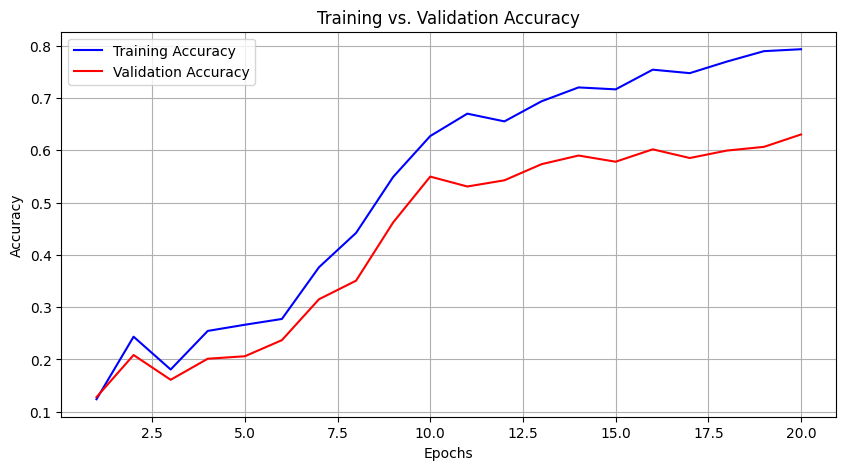

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='red')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Trial 2: Faster Learning Rate**

In [ ]:
torch.manual_seed(99) # set the random seed
# Let's try and see how well it goes
cnn = GestureClassifier(name="trial2")

##########################################
if torch.cuda.is_available():
  cnn.cuda()
##########################################

train_acc, val_acc, epochs = train(model=cnn, train_set=train_data, val_set=val_data, batch_size=128, num_epochs=30, learn_rate=0.002)

Training Started...
Epoch 1: Train accuracy: 0.15645756457564575, Validation accuracy: 0.16350710900473933
Epoch 2: Train accuracy: 0.25756457564575647, Validation accuracy: 0.22748815165876776
Epoch 3: Train accuracy: 0.3018450184501845, Validation accuracy: 0.2725118483412322
Epoch 4: Train accuracy: 0.45092250922509225, Validation accuracy: 0.35545023696682465
Epoch 5: Train accuracy: 0.5675276752767527, Validation accuracy: 0.48104265402843605
Epoch 6: Train accuracy: 0.629520295202952, Validation accuracy: 0.5284360189573459
Epoch 7: Train accuracy: 0.6974169741697417, Validation accuracy: 0.5355450236966824
Epoch 8: Train accuracy: 0.6885608856088561, Validation accuracy: 0.556872037914692
Epoch 9: Train accuracy: 0.7033210332103321, Validation accuracy: 0.5497630331753555
Epoch 10: Train accuracy: 0.7483394833948339, Validation accuracy: 0.566350710900474
Epoch 11: Train accuracy: 0.7653136531365313, Validation accuracy: 0.6066350710900474
Epoch 12: Train accuracy: 0.8, Validati

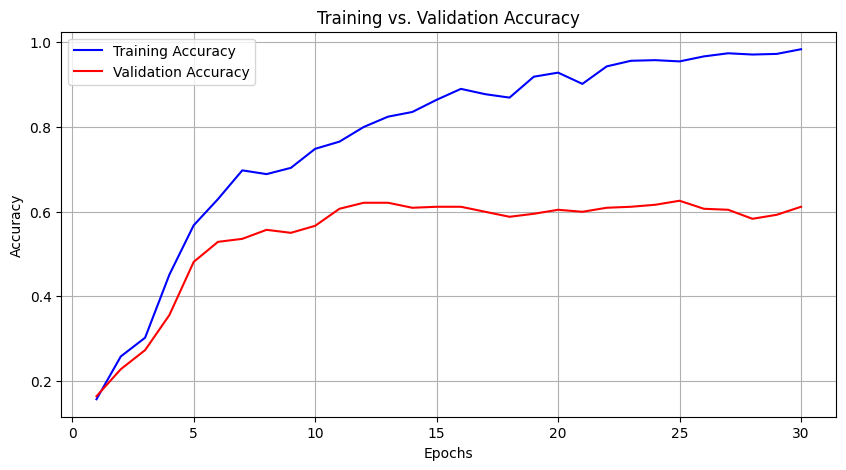

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='red')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

**Trial 4: Extra Convolutional Layer w/ Regularization Techniques**

In [ ]:
from math import floor

class ImprovedGestureClassifier(nn.Module):
    def __init__(self, name="improved_cnn_classifier"):
        super(ImprovedGestureClassifier, self).__init__()
        self.name = name

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)

        # Batch Normalization layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)
        self.bn4 = nn.BatchNorm2d(128)

        # Pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate input size for fully connected layer
        self.size1 = floor(((224 - 3 + 2) / 1 + 1) / 2)
        self.size2 = floor(((self.size1 - 3 + 2) / 1 + 1) / 2)
        self.size3 = floor(((self.size2 - 3 + 2) / 1 + 1) / 2)
        self.size4 = floor(((self.size3 - 3 + 2) / 1 + 1) / 2)
        self.fc_input = 128 * self.size4 * self.size4

        # Fully connected layers
        self.fc1 = nn.Linear(self.fc_input, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 9)

        # Dropout layer (50% probability)
        self.dropout = nn.Dropout(0.5)

    def forward(self, img):
        # Convolutional layers followed by pooling, Batch Normalization and ReLU activation
        img = self.pool(F.relu(self.bn1(self.conv1(img))))
        img = self.pool(F.relu(self.bn2(self.conv2(img))))
        img = self.pool(F.relu(self.bn3(self.conv3(img))))
        img = self.pool(F.relu(self.bn4(self.conv4(img))))

        # Flatten tensor
        img = img.view(-1, self.fc_input)

        # Fully connected layers with ReLU activation and dropout
        img = self.dropout(F.relu(self.fc1(img)))
        img = self.dropout(F.relu(self.fc2(img)))

        # Output layer
        img = self.fc3(img)

        return img

In [ ]:
torch.manual_seed(99) # set the random seed
# Let's try our default one and see how well it goes
cnn = ImprovedGestureClassifier(name="improved")

##########################################
if torch.cuda.is_available():
  cnn.cuda()
##########################################

train_acc, val_acc, epochs = train(model=cnn, train_set=train_data, val_set=val_data, batch_size=128, num_epochs=30, learn_rate=0.0009)

Training Started...
Epoch 1: Train accuracy: 0.19348534201954398, Validation accuracy: 0.17543859649122806
Epoch 2: Train accuracy: 0.3400651465798046, Validation accuracy: 0.25146198830409355
Epoch 3: Train accuracy: 0.4084690553745928, Validation accuracy: 0.3391812865497076
Epoch 4: Train accuracy: 0.5042345276872964, Validation accuracy: 0.3713450292397661
Epoch 5: Train accuracy: 0.5237785016286645, Validation accuracy: 0.4298245614035088
Epoch 6: Train accuracy: 0.6013029315960912, Validation accuracy: 0.47368421052631576
Epoch 7: Train accuracy: 0.6149837133550489, Validation accuracy: 0.47076023391812866
Epoch 8: Train accuracy: 0.6293159609120521, Validation accuracy: 0.47368421052631576
Epoch 9: Train accuracy: 0.6833876221498372, Validation accuracy: 0.5058479532163743
Epoch 10: Train accuracy: 0.7055374592833876, Validation accuracy: 0.5321637426900585
Epoch 11: Train accuracy: 0.7446254071661238, Validation accuracy: 0.564327485380117
Epoch 12: Train accuracy: 0.7504885993

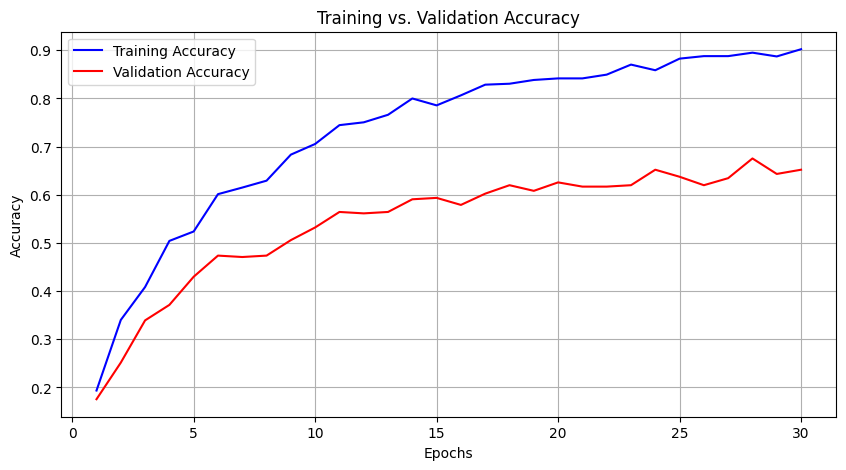

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='red')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#### Part (c) - 2 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

**Explanation**:

- I chose the model from **(trial 4 with an extra convolutional layer)** as the best performer. Despite showing signs of overfitting, with a training accuracy reaching 0.9 in 30 epochs, it achieved a significant 5% accuracy improvement over all other models.

- This suggests a better capability for feature extraction, justifying the added complexity. Although there are concerns regarding overfitting, the model's superior performance on both the training and, implicitly, validation sets suggests that the benefits outweigh the drawbacks.

- For future improvements, we could include more regularization strategies to improve the model's generalizability.

#### Part (d) - 2 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

Cool! The test accuracy is higher than the validation accuracy.

In [ ]:
get_accuracy(cnn, test_loader)

0.7280701754385965

### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

#### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [ ]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 86.6MB/s]


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [ ]:
# img = ... a PyTorch tensor with shape [N,3,224,224] containing hand images ...
# features = alexnet.features(img)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

In [ ]:
###############################################################################
# Data Loading

# Create DataLoaders
batch_size = 1
num_workers = 1

train_loader = DataLoader(train_data, batch_size=batch_size,
                          num_workers=num_workers, shuffle=True)

val_loader = DataLoader(val_data, batch_size=batch_size,
                        num_workers=num_workers, shuffle=True)

test_loader = DataLoader(test_data, batch_size=batch_size,
                         num_workers=num_workers, shuffle=True)

In [ ]:
import os
import torch

def extract_and_save_features(model, data_loader, folder_path, classes):
    """
    Extract features from the images using a given model and save them to a specified folder.
    """
    n = 0

    for img, label in data_loader:
        # Extract features and convert to tensor
        features = model.features(img)
        features_tensor = torch.from_numpy(features.detach().numpy())

        # Determine the folder name based on the class label
        class_name = str(classes[label])
        class_folder = os.path.join(folder_path, class_name)

        # Create class directory if it doesn't exist
        if not os.path.isdir(class_folder):
            os.mkdir(class_folder)

        # Save the feature tensor to the class directory
        tensor_filename = os.path.join(class_folder, f"{n}.tensor")
        torch.save(features_tensor.squeeze(0), tensor_filename)

        n += 1

In [ ]:
# Define paths and classes
PATH = '/content/drive/MyDrive/aps360Labs/LAB3_dataset/features/'
classes = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# Extract and save features for training, validation, and test datasets
extract_and_save_features(alexnet, train_loader, os.path.join(PATH, 'train'), classes)
extract_and_save_features(alexnet, val_loader, os.path.join(PATH, 'val'), classes)
extract_and_save_features(alexnet, test_loader, os.path.join(PATH, 'test'), classes)

#### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

**Explanation**:
*  **Architecture**: I chose a simple 4-layer structure—1 convolutional, 1 max pooling, and 2 fully connected layers.

*  **Convolutional Layer**: I increased the output channels in response to the rich input from AlexNet features.

*  **Pooling Layer**: I implemented a max pooling with a kernel size of 2, which is a standard choice for reducing dimensionality while preserving features.

*  **Activation Function**: I chose to use ReLU due to its widespread success in adding non-linearity without significant computational cost.

*  **Layer Configuration**: I cut down on the amount of convolutional layers and hidden units to make the most of AlexNet's advanced features and boost efficiency without lowering performance.

In [ ]:
torch.manual_seed(99) # set the random seed
from math import floor

class AlexNetClassifier(nn.Module):
  def __init__(self, name = "alx_classifier"):
    super(AlexNetClassifier, self).__init__()
    self.name = name

    # Convolutional layers
    self.conv1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1)

    # Pooling layer
    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    # Calculate the input size into the fc layers
    self.size1 = floor(((6 - 3 + 2)/1 + 1)/2) # 3-kernel size, 2-padding time 2, 1 - stride, /2 - max pooling
    self.fc_input = 512*self.size1*self.size1

    # Fully connected (ANN) layers
    self.fc1 = nn.Linear(self.fc_input, 32)
    self.fc2 = nn.Linear(32, 9)  # 9 classes

  def forward(self, features):
    # Convolutional layers followed by pooling and ReLU activation
    img = self.pool(F.relu(self.conv1(features)))

    # Flatten the tensor
    img = img.view(-1, self.fc_input)

    # Fully connected layers with ReLU activation
    img = F.relu(self.fc1(img))

    # Final fully connected layer (no activation as it will be used with CrossEntropyLoss)
    img = self.fc2(img)

    return F.softmax(img, dim=1)

#### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [ ]:
# Helper function 3
def load_features_from_path(path):
    return torchvision.datasets.DatasetFolder(path, loader=torch.load, extensions=('.tensor'))

# Helper function 4
# Create DataLoaders for each feature set
def create_feature_dataloader(dataset):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

In [ ]:
# Load the AlexNet features as input

# Paths
PATH = '/content/drive/MyDrive/aps360Labs/LAB3_dataset/features/'
train_path = PATH + 'train'
val_path = PATH + 'val'
test_path = PATH + 'test'

# Load features from the given paths using DatasetFolder
train_features = load_features_from_path(train_path)
val_features = load_features_from_path(val_path)
test_features = load_features_from_path(test_path)

# Set DataLoader parameters
batch_size = 32
num_workers = 1

# Create DataLoaders for each feature set
train_feature_loader = create_feature_dataloader(train_features)
val_feature_loader = create_feature_dataloader(val_features)
test_feature_loader = create_feature_dataloader(test_features)

**The default trainning hyperparameters ends up to be the best model after several trials. 😆**

In [ ]:
torch.manual_seed(99) # set the random seed
alx_net = AlexNetClassifier()
if use_cuda and torch.cuda.is_available():
  alx_net.cuda()

train_acc, val_acc, epochs = train(model=alx_net, train_set=train_features, val_set=val_features,
                                   batch_size=128, num_epochs=30, learn_rate=0.001)

Training Started...
Epoch 1: Train accuracy: 0.637785016286645, Validation accuracy: 0.52046783625731
Epoch 2: Train accuracy: 0.7758957654723126, Validation accuracy: 0.6666666666666666
Epoch 3: Train accuracy: 0.8332247557003257, Validation accuracy: 0.7251461988304093
Epoch 4: Train accuracy: 0.8495114006514658, Validation accuracy: 0.7368421052631579
Epoch 5: Train accuracy: 0.8579804560260587, Validation accuracy: 0.7456140350877193
Epoch 6: Train accuracy: 0.8657980456026059, Validation accuracy: 0.7631578947368421
Epoch 7: Train accuracy: 0.8664495114006515, Validation accuracy: 0.7748538011695907
Epoch 8: Train accuracy: 0.8703583061889251, Validation accuracy: 0.7514619883040936
Epoch 9: Train accuracy: 0.8710097719869707, Validation accuracy: 0.7573099415204678
Epoch 10: Train accuracy: 0.8723127035830619, Validation accuracy: 0.7543859649122807
Epoch 11: Train accuracy: 0.9368078175895765, Validation accuracy: 0.8157894736842105
Epoch 12: Train accuracy: 0.9576547231270358, 

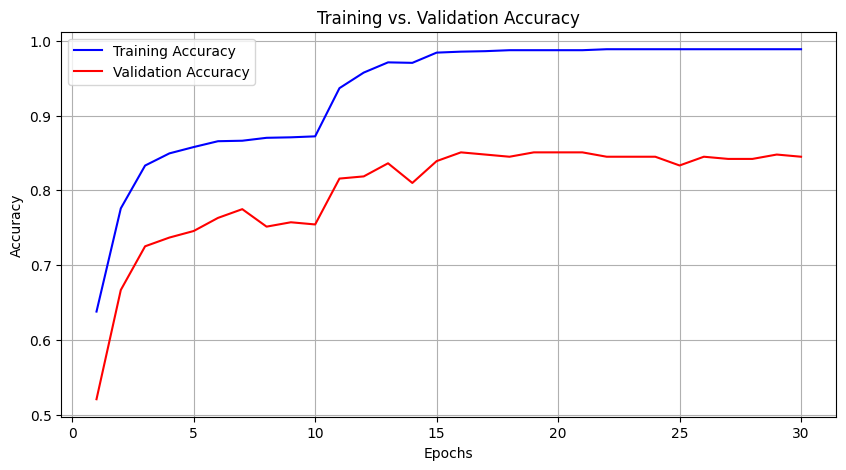

In [ ]:
# Plotting Training vs. Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_acc, label="Training Accuracy", color='blue')
plt.plot(epochs, val_acc, label="Validation Accuracy", color='red')
plt.title("Training vs. Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

#### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

Indeed, the test accuracy is **way better** than the model that I built without transfer learning. 😆

In [ ]:
get_accuracy(alx_net, test_feature_loader)

0.8771929824561403

### 5. Additional Testing [5 pt]
As a final step in testing we will be revisiting the sample images that you had collected and submitted at the start of this lab. These sample images should be untouched and will be used to demonstrate how well your model works at identifying your hand guestures.

Using the best transfer learning model developed in Part 4. Report the test accuracy on your sample images and how it compares to the test accuracy obtained in Part 4(d)? How well did your model do for the different hand guestures? Provide an explanation for why you think your model performed the way it did?

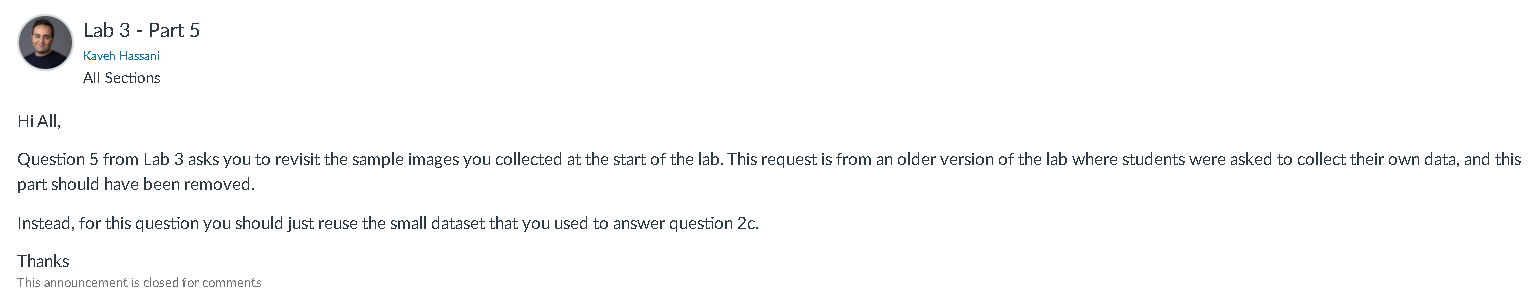

**"Instead, for this question you should just reuse the small dataset that you used to answer question 2c."** - Noted from Professor

So for this part, we are following the same steps as part 4 (a), (b), (c), but we will use the small dataset that we created in part 2 (c).

**Explanation**:
* **Test Accuracy**: It achieved a perfect test accuracy (1.0) on the sample images, showing the effectiveness of transfer learning with AlexNet features.

* **Comparison to Part 4(d)**: This test accuracy is higher than the result in part 4(d) since we are using a much smaller dataset. Thus, showing this overfitting result.

* **Model Performance**: The model demonstrated excellent recognition across all hand gesture variations, likely due to the rich features extraction capabilities inherited from AlexNet.

* **Reason for Performance**: The success is on account to the advanced feature representations from AlexNet, which enhanced the simpler neural network structure used in this transfer learning approach.

In [ ]:
# Load and prepare for the smaller dataset
# Create DataLoaders
batch_size = 1 # to extract file 1 by 1
num_workers = 1

small_loader = DataLoader(small_set, batch_size=batch_size,
                          num_workers=num_workers, shuffle=True)

In [ ]:
# Extract and save features for the small dataset (that we used in part 2c)
extract_and_save_features(alexnet, small_loader, os.path.join(PATH, 'small'), classes)

# Paths
PATH = '/content/drive/MyDrive/aps360Labs/LAB3_dataset/features/'
small_path = PATH + 'small'

small_features = load_features_from_path(small_path)

# Set DataLoader parameters
batch_size = 32
num_workers = 1

# to get ready for the resurlt
small_feature_loader = create_feature_dataloader(small_features)

In [ ]:
get_accuracy(alx_net, small_feature_loader)

1.0